Name: Aaron Bastian

## Introduction

The purpose of this notebook is to simulate solving a real world machine learning classification problem.  I use several ensemble tree models (XGBoost and Light GBM) to predict whether a user's activity on a company website will translate to a sale with ~94% accuracy and good precision.  This would allow for the comapny to optimize their website, better target their marketing, and incorporate dynamic pricing into their site in order to boost revenue.

## Data
#### Source: 
[Kaggle Link](https://www.kaggle.com/competitions/online-purchase-prediction/data?select=shop_train.csv)

#### Description:
Each row represents a user's session on an online store.  The following are the column/feature descriptions:

`admin_pages`, `info_pages`, `product_pages` - number of pages in different categories visited by the user  
`admin_seconds`, `info_seconds`, `product_seconds` - time spent by the user on different page categories  
`page_value`, `bounce_rate`, `quit_rate` - numbers from Google Analytics  
`is_holiday` - the proximity of important days for retail (such as the New Year)  
`month` - month (categorical variable)  
`operating_system_id`, `browser_id`, `region_id`, `traffic_type_id` are also categorical variables, although they are written as numbers  
`is_new_visitor`, `is_weekend` - binary signs  
`has_purchase` - binary attribute, target variable. It is he who needs to learn to predict.  

In [1]:
# Imports
from sklearn.preprocessing import StandardScaler, FunctionTransformer # Preparing the data for the models
from sklearn.model_selection import train_test_split # Dividing the data into training and validation data
from sklearn.pipeline import Pipeline # Expediting iteritive process and ensure reproducibility
from lightgbm import LGBMClassifier # Machine learning ensemble tree classifier
from xgboost import XGBClassifier # Machine learning ensemble tree classifier
import pandas as pd # Importing and handling data
import numpy as np # Matrix operations

In [2]:
# load the data and check data types
train_df = pd.read_csv("Data/shop_train.csv")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6165 entries, 0 to 6164
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   admin_pages          6165 non-null   int64  
 1   admin_seconds        6165 non-null   float64
 2   info_pages           6165 non-null   int64  
 3   info_seconds         6165 non-null   float64
 4   product_pages        6165 non-null   int64  
 5   product_seconds      6165 non-null   float64
 6   bounce_rate          6165 non-null   float64
 7   quit_rate            6165 non-null   float64
 8   page_value           6165 non-null   float64
 9   is_holiday           6165 non-null   float64
 10  month                6165 non-null   object 
 11  operating_system_id  6165 non-null   int64  
 12  browser_id           6165 non-null   int64  
 13  region_id            6165 non-null   int64  
 14  traffic_type_id      6165 non-null   int64  
 15  is_new_visitor       6165 non-null   i

In [3]:
train_df.describe() # Look at general data distributions, size, and noise.

,admin_pages,admin_seconds,info_pages,info_seconds,product_pages,product_seconds,bounce_rate,quit_rate,page_value,is_holiday,operating_system_id,browser_id,region_id,traffic_type_id,is_new_visitor,is_weekend,has_purchase
count,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000
mean,2.335280,80.852833,0.507867,33.280329,32.408273,1208.587423,0.021689,0.042682,5.937796,0.060697,2.122952,2.392863,3.086456,4.074615,0.133658,0.230170,0.154745
std,3.356446,175.414952,1.272868,134.065358,45.243435,1810.567652,0.047605,0.047973,18.211659,0.198423,0.906463,1.787116,2.377666,4.054737,0.340312,0.420976,0.361690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,191.000000,0.000000,0.014196,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,7.600000,0.000000,0.000000,18.000000,608.883333,0.003188,0.025492,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,93.300000,0.000000,0.000000,38.000000,1503.250000,0.016667,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000
max,27.000000,2720.500000,16.000000,2256.916667,686.000000,24844.156200,0.200000,0.200000,360.953384,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000,1.000000,1.000000


Our target variable will be `has_purchase`.  This is of course heavily skewed as most users will not purchase anything, and in this case it appears that about 15.5% of users made purchases (we can use the mean because it is a binary variable).  Thus, our target accuracy will be >84.5%, which is what a model could achieve by simply predicting 0 (no purchase) for eveything.  I will also be utilizing Ensemble methods for my classifier, as they are more resistant to skew and overfitting by wieghting their internal models.  In particular, I will use the `XGBClassifier` class from `xgboost`.

In [5]:
X = train_df.drop("has_purchase", axis=1) # features
y = train_df.has_purchase # target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, # Divide into training and validation data
                                        stratify=y, # ensure same proportion of target variable
                                        random_state=69 # for reproducibility
                                        )

y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True) # show the 

(0    0.845339
 1    0.154661
 Name: has_purchase, dtype: float64,
 0    0.845006
 1    0.154994
 Name: has_purchase, dtype: float64)

`month` is a string value representing the month.  I will transform this to a continuous integer column with a custom `FunctionTransformer` so the classifiers can interpret it.  I am making it continuous rather than categorical because there is an inherent order to the months of the year.

In [6]:
month_dict = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "june": 6,"jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}


def custom(old_df): # Custom transform function
    new_df = old_df.copy()
    new_df.month = new_df.month.apply(str.lower).map(month_dict) # converts month to numerical ordinal values

    new_df["total_time"] = new_df[["admin_seconds", "info_seconds", "product_seconds"]].sum(axis=1) # Create new descriptive variables
    new_df["avg_time"] = new_df.total_time / 3

    return new_df

As the data is also not on the same scale, I will scale it using the `StandardScaler`.  This will also help to reduce some of the noise in the data.  I will also create a pipeline that transforms the month variable, scales the data, and then fits to the xgb classifier to make the code more conscise and changes more clear.

In [7]:
steps = [
    ("month_trans", FunctionTransformer(custom)),
    ("scaler", StandardScaler()),
    ("xgboost", XGBClassifier())
]

pipe = Pipeline(steps)

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('month_trans',
                 FunctionTransformer(func=<function custom at 0x13e7cab00>)),
                ('scaler', StandardScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None...e,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

I make a simple function `analyze_model` that takes a sklearn model or pipeline as an input and prints out some relevant metrics for analyzing model performance.  
I have chosen the following markers:  
1. **Accuracy** : Mostly to look for overfitting, but also to compare to the benchmark accuracy.
2. **F1-Score** : Because target precision and recall are both important for the business case.
3. **ROC_AUC** : For a similar reason as using F1, it's insensitive to the imbalance and it's robust to the different costs of false negatives and false positives.
4. **Confusion Matrix** : To visualize the the distribution of error types.

Training Acc:  0.9987021414665801
Training F1:  0.9957865168539326
Training AUC:  0.9958041958041959

Validation Acc:  0.8955901426718548
Validation F1:  0.639821029082774
Validation AUC:  0.7742207393944452
Validation Precision:  0.6875


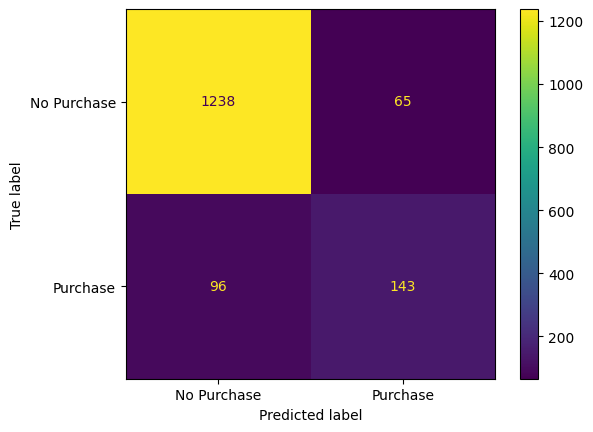

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def analyze_model(model) -> None:

    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)

    print("Training Acc: ", accuracy_score(y_train, train_preds))
    print("Training F1: ", f1_score(y_train, train_preds))
    print("Training AUC: ", roc_auc_score(y_train, train_preds))
    print()
    print("Validation Acc: ", accuracy_score(y_valid, valid_preds))
    print("Validation F1: ", f1_score(y_valid, valid_preds))
    print("Validation AUC: ", roc_auc_score(y_valid, valid_preds))
    print("Validation Precision: ", precision_score(y_valid, valid_preds))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_valid, valid_preds, labels=model.classes_), display_labels=["No Purchase", "Purchase"])
    disp.plot()
    plt.show()

analyze_model(pipe)


Not bad.  We are already outperforming our benchmark of 84.5% Accuracy, but we can do better.  It appears that we are overfitting our data, as we have a near perfect accuracy on out training data and signifficantly lower accuracy on our Validation data (11%), and our F1 and AUC fall drastically in the validation data.  I will tune the pipeline/model hyperparameters to do this, using a grid search cross validation as the dataset is not too large and there are only three hyperparameters I would like to tune.  
1 and 2: `n_estimators` (default is 100) and `max_depth` (default is 6) | To reduce overfitting  
3: `scale_pos_weight` (default 1) | to balance the weight of the positive class (minority class)  

[docs](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [10]:
from sklearn.model_selection import GridSearchCV

pipe_2 = Pipeline([
    ("custom_transformer", FunctionTransformer(custom)),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier())
])

param_grid = {
    "xgb__max_depth": [2, 3, 5, 6], # Model Complexity / Overfitting
    "xgb__n_estimators" : [50, 75, 100], # Model Complexity / Overfitting
    "xgb__scale_pos_weight" : [0, 1, 2, 3] # Class Imbalance
    
}

grid_search = GridSearchCV(pipe_2, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'xgb__max_depth': 2, 'xgb__n_estimators': 50, 'xgb__scale_pos_weight': 2}

The Grid search revealed that we should decrease our `max_depth` to 2 and our `n_estimators` to 50.  This makes sense as setting both of these parameters too high can lead to high variance and overfitting.  It also said to keep the weight scale at the default value of 1 which is suprising.

Training Acc:  0.9043910880380706
Training F1:  0.7068965517241379
Training AUC:  0.8394621754908348

Validation Acc:  0.893644617380026
Validation F1:  0.6833976833976834
Validation AUC:  0.8311524419026579
Validation Precision:  0.6344086021505376


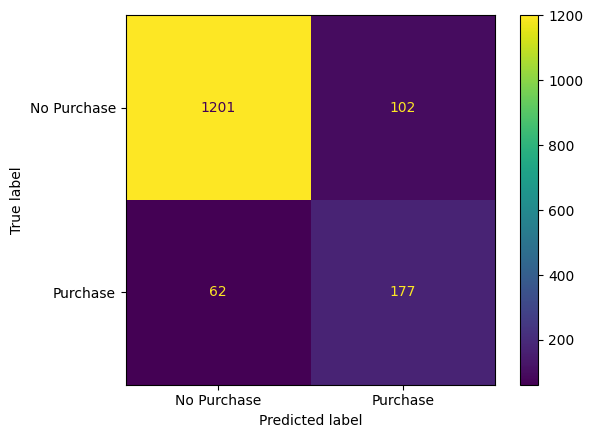

In [11]:
pipe_2.set_params(**grid_search.best_params_)   # unpacks the dict object into an array of params

pipe_2.fit(X_train, y_train)

analyze_model(pipe_2)

A Validation accuracy of 90% which is only a 0.4% increase from our baseline model, but our F1 and AUC are also higher and more evenly spread between the training and validation models.

Here is a simple function that formats the model predictions for Kaggle submission and exports to a provided file.

In [12]:
final_X = pd.read_csv("Data/shop_test.csv")

def create_submission(model, out_file_name:str):
    test_preds = model.predict_proba(final_X)[:,1]
    sub = pd.DataFrame(test_preds, columns=["prediction"])
    sub["id"] = sub.index
    sub.to_csv(out_file_name, index=False)

create_submission(pipe_2, "XGB_sub.csv")

The submissions for the Kaggle competition required the predicitons to be in the form of probabilities so they could calculate the ROC as the evaluation metric.  I recieved a final score of 93.45.

Finally, I wanted to try using the Light GBM classifier from Microsoft, as it tends to outperform XGBoost and is much faster.  I will construct the pipeline the same way as before, substituting the `XGBClassifier` for an `LGBMClassifier`.

Training Acc:  0.9891845122215012
Training F1:  0.9642857142857144
Training AUC:  0.9707485452111861

Validation Acc:  0.8975356679636836
Validation F1:  0.640909090909091
Validation AUC:  0.7719552882469486
Validation Precision:  0.7014925373134329


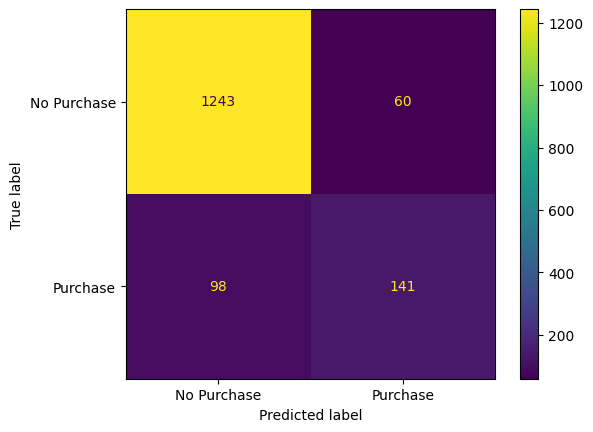

In [13]:
# Create baseline lgbm model

pipe_3 = Pipeline([
    ("custom_transformer", FunctionTransformer(custom)),
    ("scaler", StandardScaler()),
    ("lgb", LGBMClassifier())
])

pipe_3.fit(X_train, y_train)

analyze_model(pipe_3)

In [14]:
# Grid search
pipe_4 = Pipeline([
    ("custom_transformer", FunctionTransformer(custom)),
    ("scaler", StandardScaler()),
    ("lgb", LGBMClassifier())
])

param_grid = {
    "lgb__max_depth": [2, 3, 5, 6],
    "lgb__n_estimators" : [50, 75, 100],
    "lgb__scale_pos_weight" : [1, 2, 3, 5]
}

grid_search = GridSearchCV(pipe_3, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lgb__max_depth': 3, 'lgb__n_estimators': 75, 'lgb__scale_pos_weight': 2}

Training Acc:  0.9059052563270603
Training F1:  0.7109634551495017
Training AUC:  0.8415004902978291

Validation Acc:  0.8910505836575876
Validation F1:  0.6793893129770993
Validation AUC:  0.8313258428409497
Validation Precision:  0.624561403508772


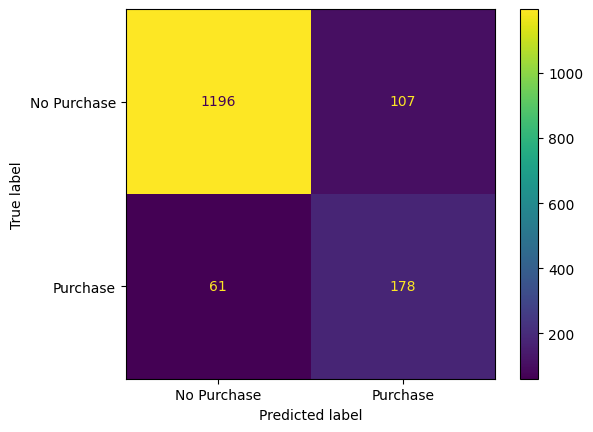

In [15]:
pipe_4.set_params(**grid_search.best_params_)

pipe_4.fit(X_train, y_train)

analyze_model(pipe_4)

In [16]:
test_preds = pipe_4.predict_proba(final_X)[:,1]

sub = pd.DataFrame(test_preds, columns=["prediction"])
sub["id"] = sub.index
sub.to_csv("lgbm_submission.csv", index=False)

Though the LGBM model had slightly lower accuracy, it had a significantly higher F1-Score and AUC-ROC, and much lower Type 1 and 2 Errors.  Upon submitting these predictions to Kaggle, I recieved a final score of 93.76.

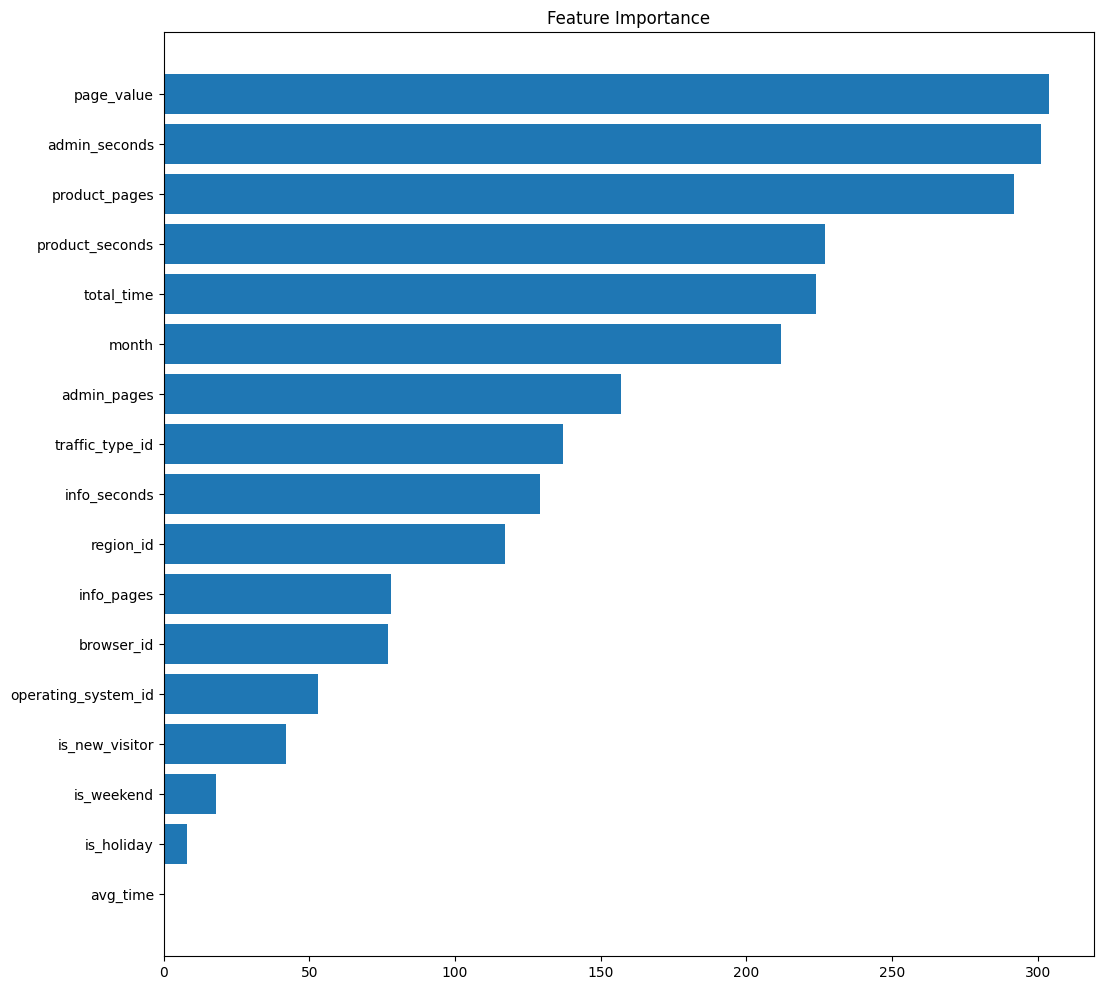

In [17]:
feature_names = [col.replace("_", " ").title() for col in custom(X_valid).columns]

feature_importances = dict(zip(custom(X_train).columns, pipe_3[-1].feature_importances_))
del feature_importances["bounce_rate"]
del feature_importances["quit_rate"]
features = pd.Series(feature_importances).sort_values(ascending=True)


fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(features)), features, align="center")
plt.yticks(range(len(features)), features.index)
plt.title('Feature Importance')
plt.show()

## Conclusion

LGBM was considerably faster to train and slightly more performant than XGBoost in this scenario.  This approach proved effective and can be used for real world prediction of purchases as well as other website and application end points.

## Business Use cases
Targeted Marketing: The company could use the predictions to target their marketing efforts to users who are most likely to buy a product. For example, they could send personalized email campaigns or display targeted ads to these users.

Dynamic Pricing: The company could use the predictions to adjust the prices of products based on a user's likelihood to purchase. For example, they could offer discounts or promotions to users who are less likely to buy a product, or charge more for users who are more likely to buy.

Churn Prediction: The company could use the predictions to identify users who are at risk of not buying again and take actions to retain them. For example, they could send personalized emails with special offers or discounts to users who are at risk of not buying.

Optimization: The company could use the predictions to optimize their website layout, design, and user experience to increase the likelihood of users buying products.